## Kernel to load: vax_inc_geo

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from textwrap import wrap
import rasterio 
import rasterio.plot
import matplotlib
import jenkspy
import random
import matplotlib.patches as mpatches
import pickle
import pycountry
import math
import warnings
warnings.simplefilter("ignore", UserWarning)
import os
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
notebook_dir = os.path.dirname(os.getcwd())
source_data_path=os.path.join(notebook_dir, "Common Source Data")

In [3]:
with open(os.path.join(source_data_path,'vaccines_sorted_by_use.pickle'),'rb') as handle:
    _,_,_,top_vaccines=pickle.load(handle)
    
top_vaccines=[(i[0],i[1],i[2]) if 'Newca' not in i[1] else (i[0],'Newcastle disease',i[2]) for i in top_vaccines]

In [4]:
SHAPEFILE = os.path.join(source_data_path,'World_Countries_Map/World_Countries__Generalized_.shp')

# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)
geo_df=geo_df.loc[:,['COUNTRY', 'ISO', 'geometry']]
geo_df.head(3)

,COUNTRY,ISO,geometry
0,Afghanistan,AF,"POLYGON ((61.27655 35.60725, 61.29638 35.62854..."
1,Albania,AL,"POLYGON ((19.57083 41.68527, 19.58195 41.69569..."
2,Algeria,DZ,"POLYGON ((4.60335 36.88791, 4.63555 36.88638, ..."


<AxesSubplot:>

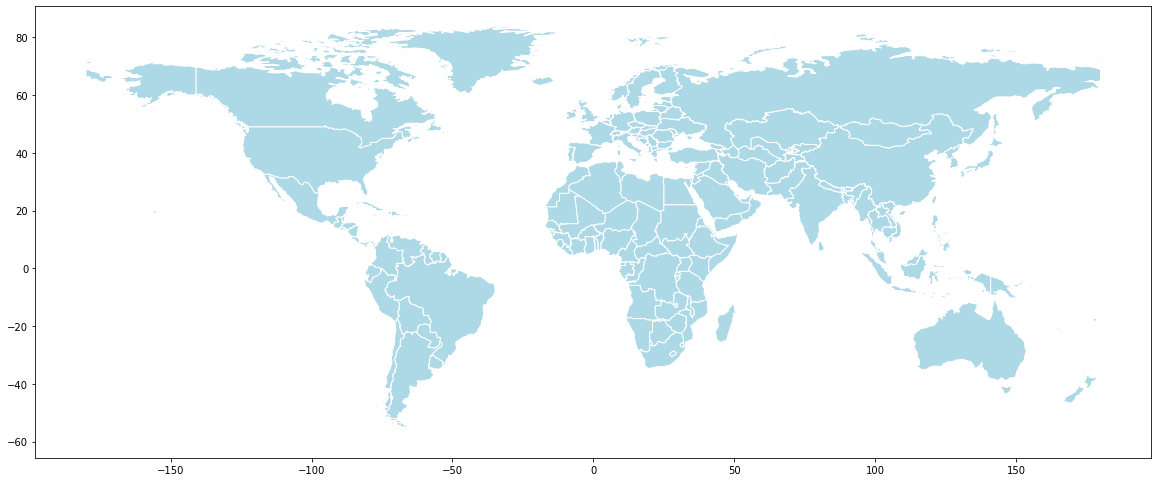

In [5]:
# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['COUNTRY'] == 'Antarctica'].index)
geo_df.reset_index(drop=True, inplace=True)

# Print the map
geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

In [6]:
pop_countries_geo = geo_df['ISO']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3


codes_pop_geo = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_geo]

iso3s_pop_geo=[]

for i in pop_countries_geo:
    try:
        iso3s_pop_geo+=[countries[i]]
    except:
        iso3s_pop_geo+=[None]
        
geo_df['ISO3']=iso3s_pop_geo


print(np.unique(codes_pop_geo))

['ABW' 'AFG' 'AGO' 'AIA' 'ALB' 'AND' 'ARE' 'ARG' 'ARM' 'ASM' 'ATF' 'ATG'
 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN' 'BES' 'BFA' 'BGD' 'BGR' 'BHR' 'BHS'
 'BIH' 'BLM' 'BLR' 'BLZ' 'BMU' 'BOL' 'BRA' 'BRB' 'BRN' 'BTN' 'BVT' 'BWA'
 'CAF' 'CAN' 'CCK' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG' 'COK' 'COL'
 'COM' 'CPV' 'CRI' 'CUB' 'CUW' 'CXR' 'CYM' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA'
 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FLK'
 'FRA' 'FRO' 'FSM' 'GAB' 'GBR' 'GEO' 'GGY' 'GHA' 'GIB' 'GIN' 'GLP' 'GMB'
 'GNB' 'GNQ' 'GRC' 'GRD' 'GRL' 'GTM' 'GUF' 'GUM' 'GUY' 'HMD' 'HND' 'HRV'
 'HTI' 'HUN' 'IDN' 'IMN' 'IND' 'IOT' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA'
 'JAM' 'JEY' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR' 'KNA' 'KOR' 'KWT'
 'LAO' 'LBN' 'LBR' 'LBY' 'LCA' 'LIE' 'LKA' 'LSO' 'LTU' 'LUX' 'LVA' 'MAF'
 'MAR' 'MCO' 'MDA' 'MDG' 'MDV' 'MEX' 'MHL' 'MKD' 'MLI' 'MLT' 'MMR' 'MNE'
 'MNG' 'MNP' 'MOZ' 'MRT' 'MSR' 'MTQ' 'MUS' 'MWI' 'MYS' 'MYT' 'NAM' 'NCL'
 'NER' 'NFK' 'NGA' 'NIC' 'NIU' 'NLD' 'NOR' 'NPL' 'N

In [7]:
def format_as_superscript(number):
    log_output = math.log10(number)

    # Check if log_output is a floating-point number
    if log_output.is_integer():
        superscript_exponent = ''.join(chr(0x2070 + int(digit)) for digit in str(int(log_output)))
    else:
        log_output=round(log_output,2)
        superscript_exponent = ''.join(chr(0x2070 + int(digit)) for digit in str(int(log_output)))

    formatted_text = f"10{superscript_exponent}"
    return formatted_text


In [8]:
full_df=pd.read_csv('Supplementary Spreadsheet- Vaccination Coverage Estimates.csv')
full_df=full_df[full_df['Year']==2024]

In [9]:
def assign_category(value, categories):
    if categories[0] <= value <= categories[1]:
        return 0
    elif categories[1] < value <= categories[2]:
        return 0.25
    elif categories[2] < value <= categories[3]:
        return 0.5
    elif categories[3] < value <= categories[4]:
        return 0.75
    elif categories[4] < value <= 100:
        return 1
    else:
        return None 



In [10]:
#Function to map Category Vaccination values to specific colors in category_colors
def get_category_color(val):
    return category_colors.get(val, 'white')  # Default to white if value is not in the specified categories

# Apply colors based on "Category Vaccination"

0.0 100.0
Poultry Newcastle disease


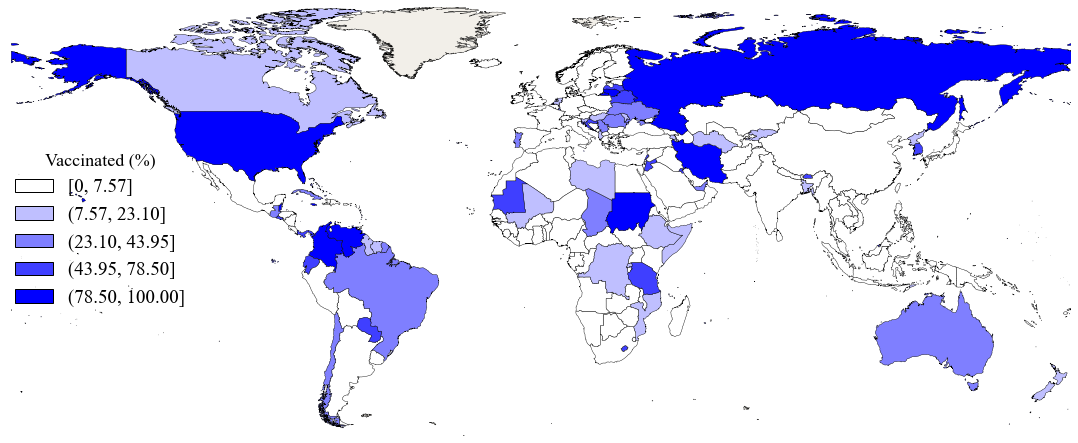

0.0 100.0
Poultry Infectious bursal disease (Gumboro disease)


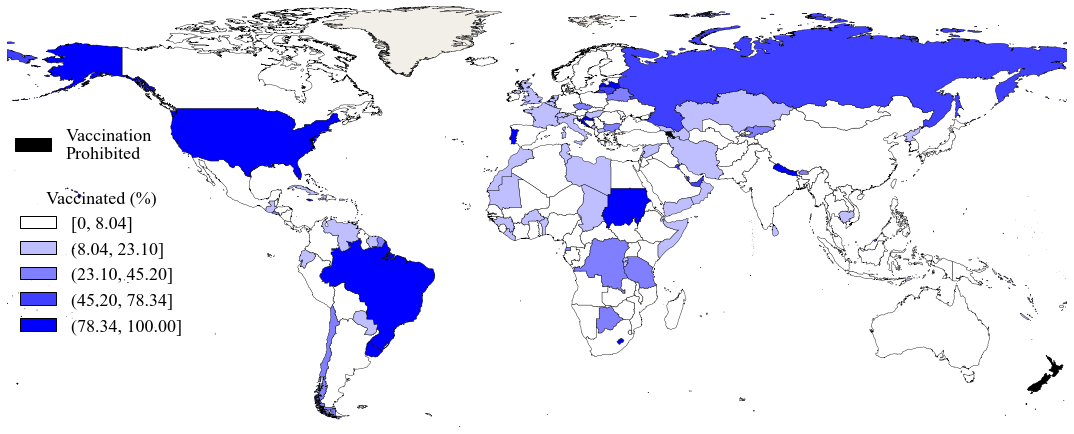

0.0 100.0
Cattle Anthrax


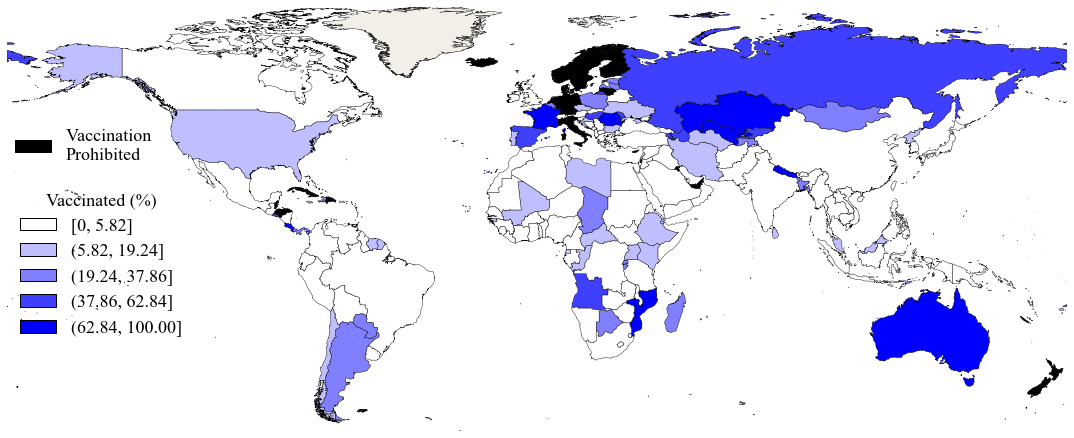

0.0 100.0
Poultry Avian infectious bronchitis


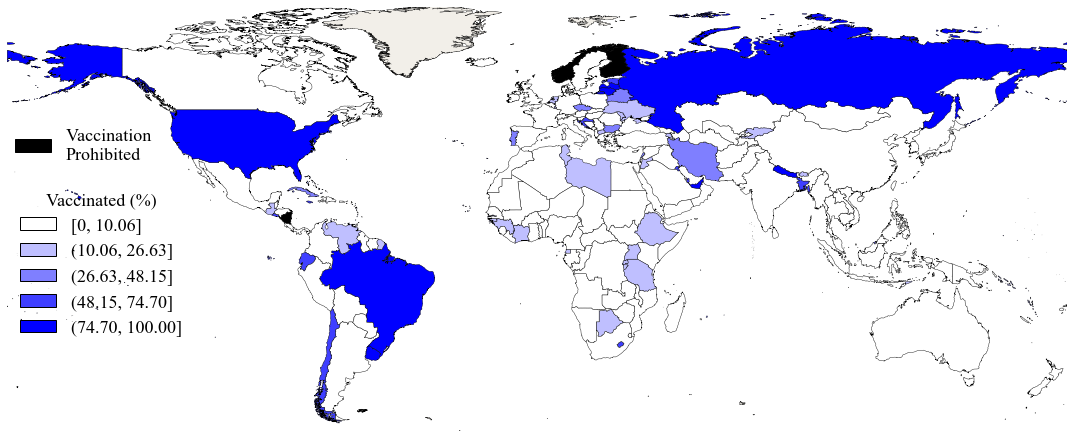

0.0 100.0
Poultry Marek's disease (-2011)


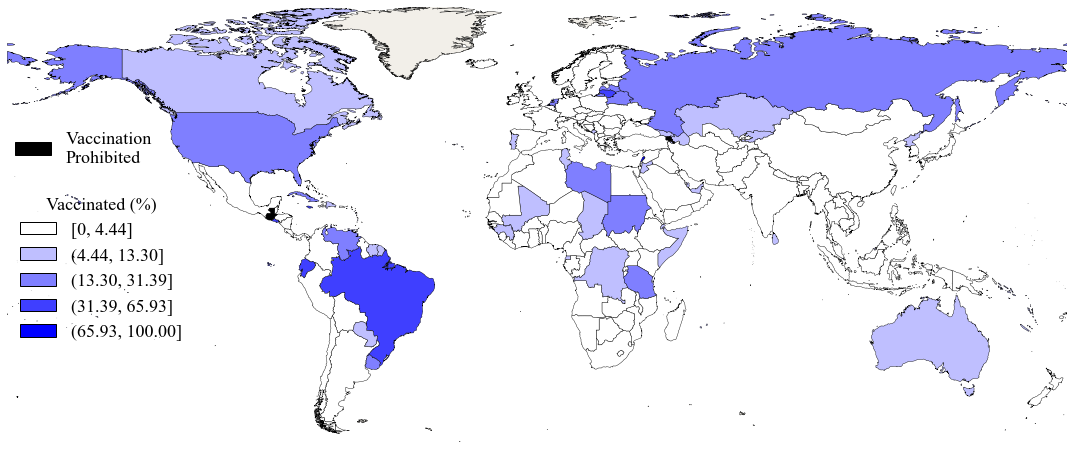

0.0 99.74093264248704
Cattle Rabies virus (Inf. with)


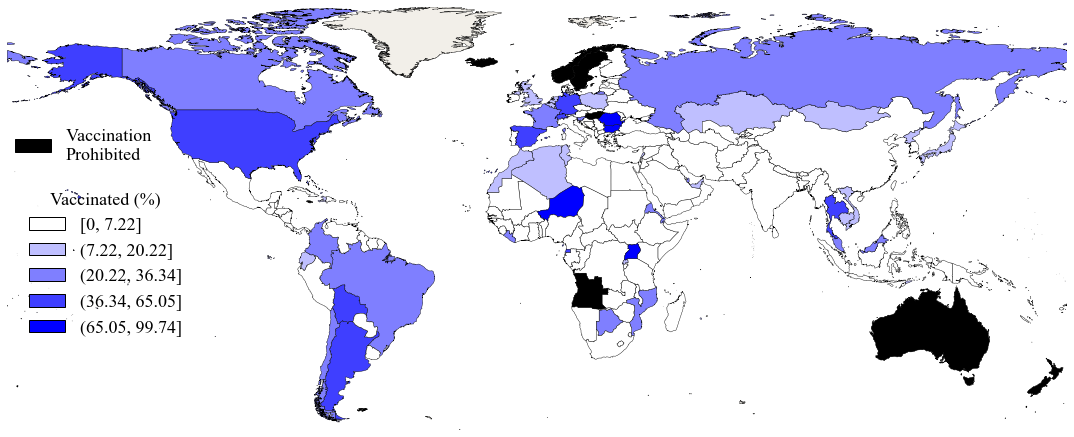

0.0 100.0
Cattle Foot and mouth disease virus (Inf. with)


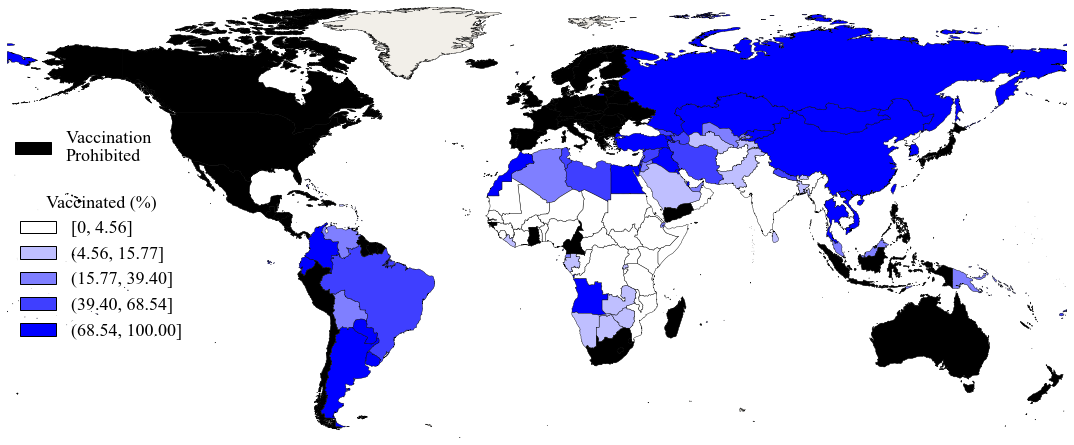

0.0 33.62440168857574
Cattle Brucella abortus (Inf. with)


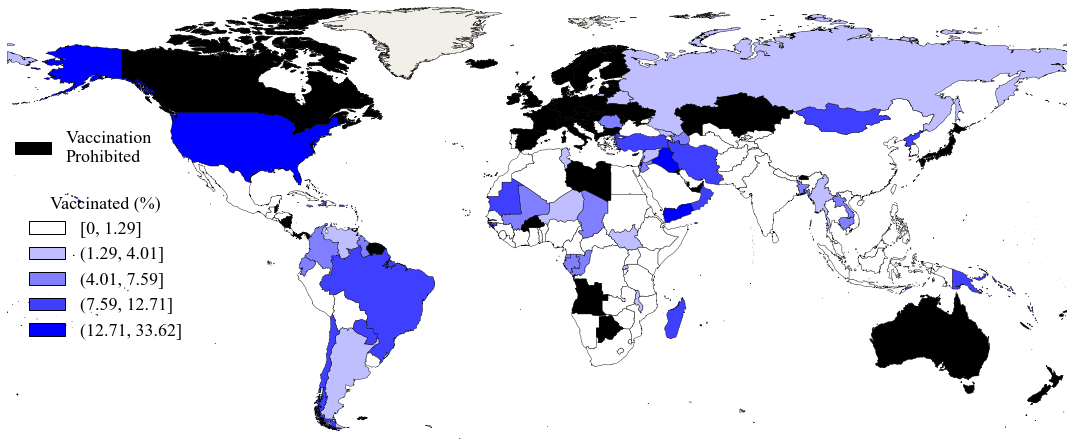

0.0 100.0
Cattle Lumpy skin disease virus (Inf. with)


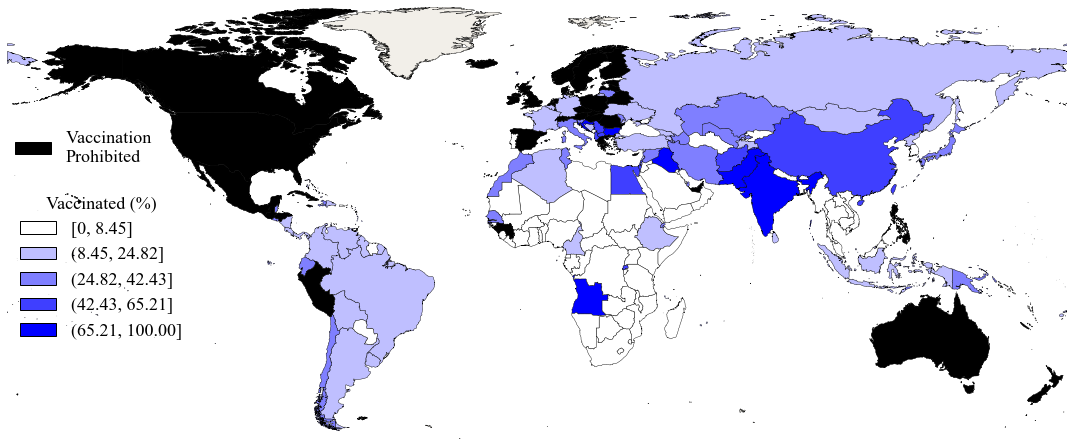

0.0 100.0
Poultry Avian infectious laryngotracheitis


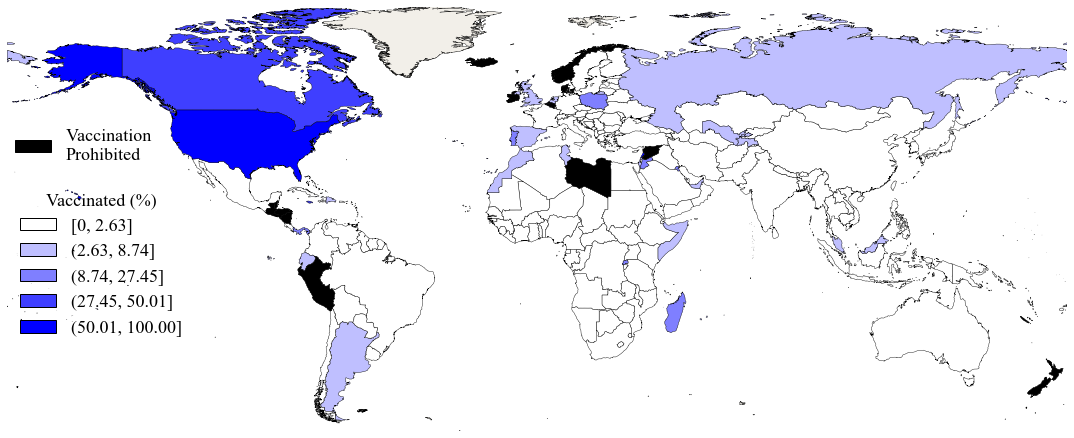

0.0 100.0
Pigs Classical swine fever virus (Inf. with)


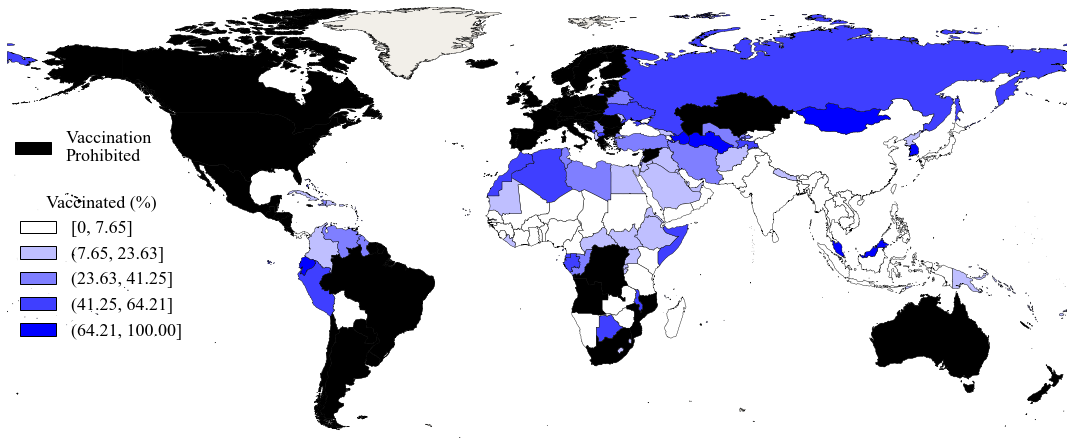

0.0 100.0
Pigs Anthrax


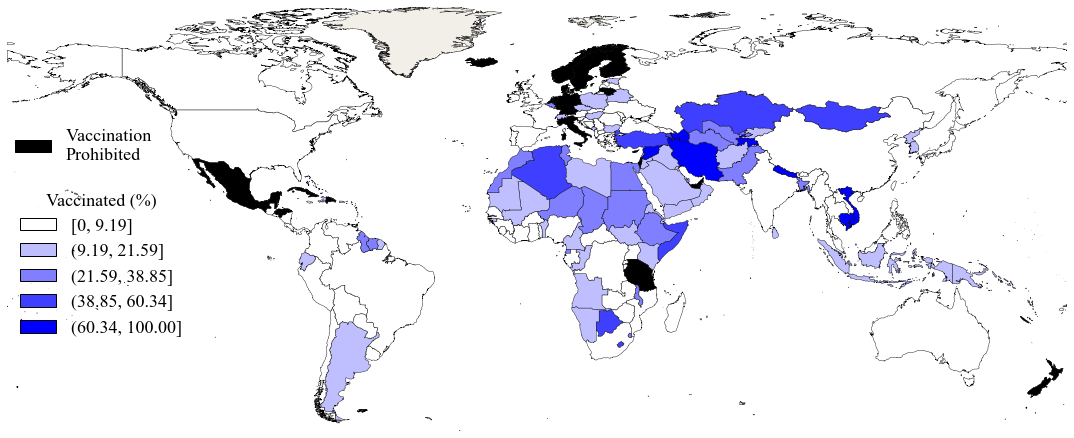

0.0 61.458333333333336
Pigs Rabies virus (Inf. with)


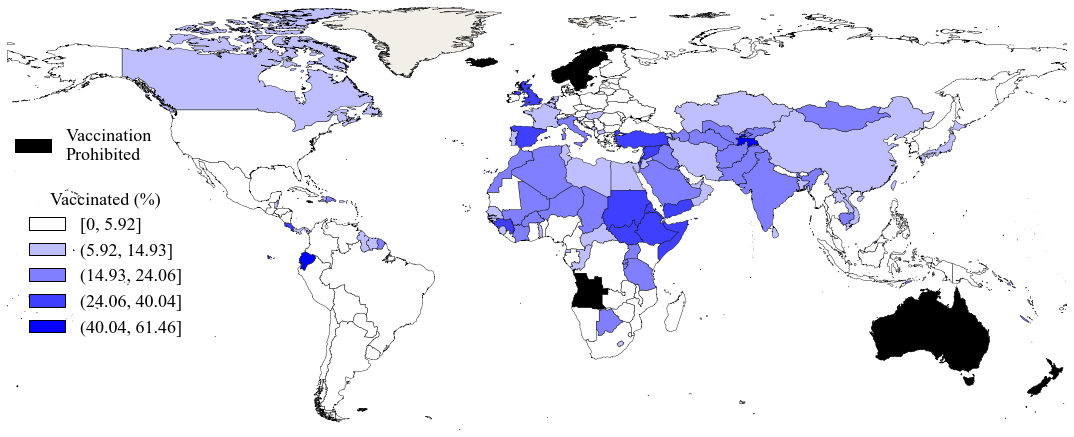

In [11]:
plt.rcParams["font.family"] = "Times New Roman"
countries_missing_data = dict()
animals=[i[0] for i in top_vaccines]
animals = ['Pigs' if i=='Swine' else i for i in animals]
vaccines=[i[1] for i in top_vaccines]

for animal, disease in zip((animals[0:10]+animals[14:17]),(vaccines[0:10]+vaccines[14:17])):
    plot_df=full_df[(full_df['Animal']==animal)&(full_df['Disease']==disease)&(full_df['Year']==2024)]
    background_color=(170 / 255, 211 / 255, 223 / 255)
        
    merged_df = pd.merge(right=plot_df,left=geo_df, how='left', left_on='ISO3', right_on='ISO3')    
    prohibited_df=merged_df[merged_df['Official Vaccination Measure']=="Vaccination prohibited"]
    
    col = 'Vaccination Coverage (%)'
    
    missing_df=merged_df[((merged_df['Official Vaccination Measure'].isna())&(merged_df[col].isna()))]

    
    cmap_custom=matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","blue"])
    
    # Define custom colormap using only 5 colors as proportions of the cmap color range (white to blue)
    category_colors = {
        0: cmap_custom(0),
        0.25: cmap_custom(0.25),
        0.5: cmap_custom(0.5),
        0.75: cmap_custom(0.75),
        1: cmap_custom(.999)
    }


    vmax_ultimate=merged_df[col].max()
    vmin_ultimate=merged_df[col].min()
    
    print(vmin_ultimate,vmax_ultimate)
    
    jenks_vals=merged_df[merged_df[col].notna()]['Vaccination Coverage (%)'].values.tolist()
    
    categories=jenkspy.jenks_breaks(jenks_vals,5)
    
    merged_df['Category Vaccination'] = merged_df['Vaccination Coverage (%)'].apply(lambda x: assign_category(x, categories))
    
    merged_df['color'] = merged_df['Category Vaccination'].apply(get_category_color)


    fig, ax = plt.subplots(1, figsize=(19, 17.5))
    ax.set_facecolor('lightseagreen')
    
    ax.axis('off')
    
    finish = merged_df.plot(color=merged_df['color'], ax=ax, edgecolor='black', linewidth=0.4, missing_kwds={'color': 'white'})
    
    
    # Adjust the axes limits to tightly fit the map
    ax.set_xlim(merged_df.total_bounds[0], merged_df.total_bounds[2])
    ax.set_ylim(merged_df.total_bounds[1], merged_df.total_bounds[3])
    
    patch1 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0), label='[0, '+'{:.2f}'.format(round(categories[1], 2))+']')
    patch2 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0.25), label='('+'{:.2f}'.format(round(categories[1], 2))+', '+'{:.2f}'.format(round(categories[2], 2))+']')
    patch3 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0.5), label='('+'{:.2f}'.format(round(categories[2], 2))+', '+'{:.2f}'.format(round(categories[3], 2))+']')
    patch4 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(0.75), label='('+'{:.2f}'.format(round(categories[3], 2))+', '+'{:.2f}'.format(round(categories[4], 2))+']')
    patch5 = mpatches.Patch(edgecolor='black', facecolor=cmap_custom(.999), label='('+'{:.2f}'.format(round(categories[4], 2))+', '+'{:.2f}'.format(round(vmax_ultimate, 2))+']')
    
    patchNone = mpatches.Patch(edgecolor='black', facecolor='black', label='Vaccination \nProhibited')
    
    #patchImputed = mpatches.Patch(edgecolor='cyan', facecolor=(0,0,0,0), label='Imputed',linewidth=2)
    
    missing_df.plot(facecolor=(242/255,239/255,233/255),edgecolor='black', linewidth=0.2, ax=ax, zorder=4)
    
    if len(prohibited_df)>0:
        prohibited_df.plot(facecolor='black', edgecolor='black', linewidth=0.2, ax=ax, zorder=4)
        prohibited_plotted=True
    else:
        prohibited_plotted=False
        
    if prohibited_plotted:
        legend2 = plt.legend(bbox_to_anchor=(0.155, 0.75), loc=1,
                        handles=[patchNone],fontsize=18,
                        frameon=False)
        
    
    if prohibited_plotted:
        
        legend = ax.legend(bbox_to_anchor=(0.18, 0.6), loc=1,
                        handles=[patch1, patch2, patch3, patch4, patch5],fontsize=18,
                        frameon=False)
    
    
        legend.set_title('Vaccinated (%)',prop={'size':18})
        
        plt.gca().add_artist(legend2)
        
    else:
        legend = plt.legend(bbox_to_anchor=(0.18, 0.7), loc=1,
                    handles=[patch1, patch2, patch3, patch4, patch5],fontsize=19,
                    frameon=False)
        
        legend.set_title('Vaccinated (%)',prop={'size':18})
        
    
        os.makedirs("Proportion vaccinated maps", exist_ok=True)

    
    plt.savefig('Proportion vaccinated maps/'+animal+'_'+disease + '.svg', format='svg', facecolor=(170 / 255, 211 / 255, 223 / 255),
                bbox_inches='tight', pad_inches=0,dpi=600)
    
    plt.savefig('Proportion vaccinated maps/'+animal+'_'+disease + '.png', format='png', facecolor=(170 / 255, 211 / 255, 223 / 255),
                bbox_inches='tight', pad_inches=0,dpi=600)
    
    print(animal,disease)
    plt.show()
    
    